# Recommendation System using user ratings

In [23]:
import gzip
import json
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
pd.options.display.float_format = '{:,}'.format
%matplotlib inline
from sklearn.model_selection import train_test_split
from keras.layers import Input, Embedding, Flatten, Dot, Dense
from keras.models import Model
from PIL import Image
import requests
from io import BytesIO


In [24]:
#Load the data

DIR = './goodreads'
PATH_IN = os.path.join(DIR, 'ratings.csv')
dataset = pd.read_csv(PATH_IN)
dataset.head()

,book_id,user_id,rating
0,1,314,5
1,1,439,3
2,1,588,5
3,1,1169,4
4,1,1185,4


In [39]:
print("Total count: \n", dataset.count())

Total count: 
 book_id    981756
user_id    981756
rating     981756
dtype: int64


In [25]:
n_users = len(dataset.user_id.unique())
n_books = len(dataset.book_id.unique())

print("Number of unique users ",n_users)
print("Number of unique books ",n_books)

Number of unique users  53424
Number of unique books  10000


In [26]:
#Create a test and train split

train, test = train_test_split(dataset, test_size=0.2, random_state=42)

In [40]:
print("Train set count: \n",train.count())
print("\n Test set count: \n",test.count())

Train set count: 
 book_id    785404
user_id    785404
rating     785404
dtype: int64

 Test set count: 
 book_id    196352
user_id    196352
rating     196352
dtype: int64


In [27]:
#Create the model

book_input = Input(shape=[1], name="Book-Input")
book_embedding = Embedding(n_books+1, 5, name="Book-Embedding")(book_input)

book_vec = Flatten(name="Flatten-Books")(book_embedding)

user_input = Input(shape=[1], name="User-Input")
user_embedding = Embedding(n_users+1, 5, name="User-Embedding")(user_input)

user_vec = Flatten(name="Flatten-Users")(user_embedding)

prod = Dot(name="Dot-Product", axes=1)([book_vec, user_vec])

model = Model([user_input, book_input], prod)
model.compile('adam', 'mean_squared_error')

In [5]:
#Train the model

history = model.fit([train.user_id, train.book_id], train.rating, epochs=10, verbose=1)
model.save('goodreads_regression_model.h5')

Epoch 1/10
24544/24544 [==============================] - 187s 8ms/step - loss: 13.7844
Epoch 2/10
24544/24544 [==============================] - 174s 7ms/step - loss: 4.6195
Epoch 3/10
24544/24544 [==============================] - 176s 7ms/step - loss: 1.8278
Epoch 4/10
24544/24544 [==============================] - 188s 8ms/step - loss: 1.2106
Epoch 5/10
24544/24544 [==============================] - 188s 8ms/step - loss: 0.9681
Epoch 6/10
24544/24544 [==============================] - 148s 6ms/step - loss: 0.8437
Epoch 7/10
24544/24544 [==============================] - 161s 7ms/step - loss: 0.7722
Epoch 8/10
24544/24544 [==============================] - 166s 7ms/step - loss: 0.7267
Epoch 9/10
24544/24544 [==============================] - 195s 8ms/step - loss: 0.6967
Epoch 10/10
24544/24544 [==============================] - 181s 7ms/step - loss: 0.6748


In [51]:
# Extract embeddings
book_embed = model.get_layer('Book-Embedding')
book_embed_weights = book_em.get_weights()[0]

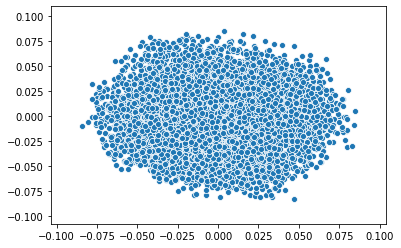

In [52]:
#Visualising the embeddings

from sklearn.decomposition import PCA
import seaborn as sns

pca = PCA(n_components=2)
pca_result = pca.fit_transform(book_embed_weights)
sns.scatterplot(x=pca_result[:,0], y=pca_result[:,1])

In [44]:
# Creating dataset for making recommendations for a particular user

book_data = np.array(list(set(dataset.book_id)))
user = np.array([2 for i in range(len(book_data))])
#Make the prediction

predictions = model.predict([user, book_data])
predictions = np.array([a[0] for a in predictions])

#Recommend the book with maximum ratings

recommended_book_ids = (-predictions).argsort()[:10]

In [29]:
#Load the book dataset

PATH_BOOKS = os.path.join(DIR, 'books.csv')
books = pd.read_csv(PATH_BOOKS)
books.head()

,id,book_id,best_book_id,work_id,books_count,isbn,isbn13,authors,original_publication_year,original_title,...,ratings_count,work_ratings_count,work_text_reviews_count,ratings_1,ratings_2,ratings_3,ratings_4,ratings_5,image_url,small_image_url
0,1,2767052,2767052,2792775,272,439023483,"9,780,439,023,480.0",Suzanne Collins,"2,008.0",The Hunger Games,...,4780653,4942365,155254,66715,127936,560092,1481305,2706317,https://images.gr-assets.com/books/1447303603m...,https://images.gr-assets.com/books/1447303603s...
1,2,3,3,4640799,491,439554934,"9,780,439,554,930.0","J.K. Rowling, Mary GrandPré","1,997.0",Harry Potter and the Philosopher's Stone,...,4602479,4800065,75867,75504,101676,455024,1156318,3011543,https://images.gr-assets.com/books/1474154022m...,https://images.gr-assets.com/books/1474154022s...
2,3,41865,41865,3212258,226,316015849,"9,780,316,015,840.0",Stephenie Meyer,"2,005.0",Twilight,...,3866839,3916824,95009,456191,436802,793319,875073,1355439,https://images.gr-assets.com/books/1361039443m...,https://images.gr-assets.com/books/1361039443s...
3,4,2657,2657,3275794,487,61120081,"9,780,061,120,080.0",Harper Lee,"1,960.0",To Kill a Mockingbird,...,3198671,3340896,72586,60427,117415,446835,1001952,1714267,https://images.gr-assets.com/books/1361975680m...,https://images.gr-assets.com/books/1361975680s...
4,5,4671,4671,245494,1356,743273567,"9,780,743,273,560.0",F. Scott Fitzgerald,"1,925.0",The Great Gatsby,...,2683664,2773745,51992,86236,197621,606158,936012,947718,https://images.gr-assets.com/books/1490528560m...,https://images.gr-assets.com/books/1490528560s...


In [30]:
#Get addditional info from book dataset

rec=books[books['id'].isin(recommended_book_ids)]

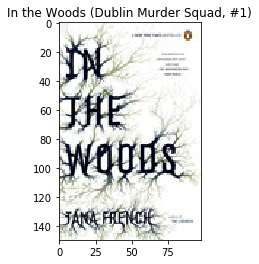

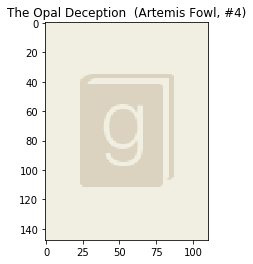

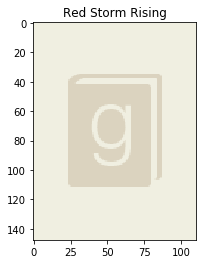

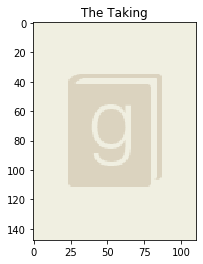

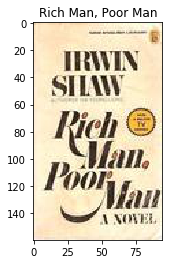

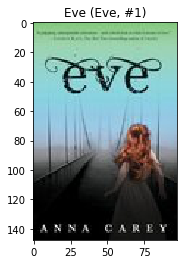

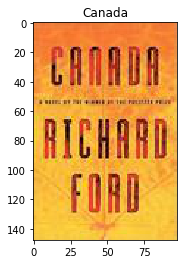

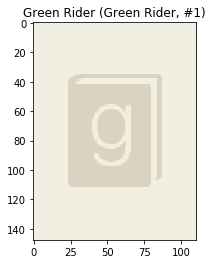

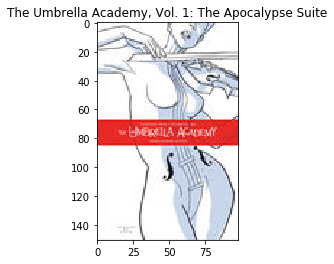

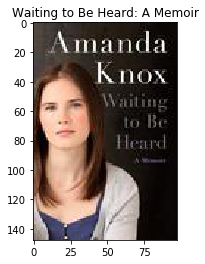

In [31]:
#Display the recommended books

for index, row in rec.iterrows():

        response = requests.get(row['image_url'])
        img = Image.open(BytesIO(response.content))
        plt.figure()
        plt.imshow(img)
        plt.title(row['title'])